[View in Colaboratory](https://colab.research.google.com/github/jagatfx/turicreate-colab/blob/master/turicreate_style_transfer.ipynb)

# Style Transfer
https://apple.github.io/turicreate/docs/userguide/style_transfer/

Style Transfer is a task takes the stylistic elements of a style image and imitates them onto another image while preserving the content of the other image.


## How it works
https://apple.github.io/turicreate/docs/userguide/style_transfer/how-it-works.html

The style transfer system in Turi Create uses Convolutional Neural Networks (CNNs) to create high quality artistic images. Broadly speaking, we use CNNs to separate and recombine the content and style elements of arbitrary images.

### Style transfer model
The technique used in Turi Create is based on "[A Learned Representation For Artistic Style](https://arxiv.org/pdf/1610.07629.pdf)". The model is compact and fast and hence can run on mobile devices like an iPhone. The model consists of 3 convolutional layers, 5 residual layers (2 convolutional layers in each) and 3 upsampling layers each followed by a convolutional layer. There are a total of 16 convolutional layers.

There are three aspects about this technique that are worth noting:
*   It is designed to be incredibly fast at stylizing images, allowing deployment on device. As a trade off, the model creation takes longer.
*   A single model can incorporate a large number of styles without any significant increase in the size of the model.
The model can take input of any size and output a stylized image of the same size.

During training, we employ Transfer Learning. The model uses the visual semantics of an already trained VGG-16 network to understand and mimic stylistic elements. It also updates only a small set of the parameters of the stylization network; the rest of the parameters were already trained and remain unchanged. This allows you to achieve great results with little data and shorter training time.

![VGG-16](https://www.cs.toronto.edu/~frossard/post/vgg16/vgg16.png)

VGG16 is a very deep network with several convolution layers followed by max-pooling.

## Turi Create and GPU Setup

In [0]:
!apt install libnvrtc8.0
!pip uninstall -y mxnet-cu80 && pip install mxnet-cu80==1.1.0
!pip install turicreate

## Google Drive Access

You will be asked to click a link to generate a secret key to access your Google Drive. 

Copy and paste secret key it into the space provided with the notebook.

In [0]:
import os.path
from google.colab import drive

# mount Google Drive to /content/drive/My Drive/
if os.path.isdir("/content/drive/My Drive"):
  print("Google Drive already mounted")
else:
  drive.mount('/content/drive')

## Fetch Data

### Choose Style Images

Pick some images from https://images.nga.gov

With the launch of NGA Images, the National Gallery of Art implements an open access policy for digital images of works of art that the Gallery believes to be in the public domain. Images of these works are now available free of charge for any use, commercial or non-commercial. Users do not need to contact the Gallery for authorization to use these images. They are available for download at the NGA Images website (images.nga.gov). See Policy Details below for specific instructions and notes for users.

In [0]:
import os.path
import urllib.request
import tarfile
import zipfile
import gzip
from shutil import copy

def fetch_remote_datafile(filename, remote_url):
  if os.path.isfile("./" + filename):
    print("already have " + filename + " in workspace")
    return
  print("fetching " + filename + " from " + remote_url + "...")
  urllib.request.urlretrieve(remote_url, "./" + filename)

def cache_datafile_in_drive(filename):
  if os.path.isfile("./" + filename) == False:
    print("cannot cache " + filename + ", it is not in workspace")
    return
  
  data_drive_path = "/content/drive/My Drive/Colab Notebooks/data/"
  if os.path.isfile(data_drive_path + filename):
    print("" + filename + " has already been stored in Google Drive")
  else:
    print("copying " + filename + " to " + data_drive_path)
    copy("./" + filename, data_drive_path)
  

def load_datafile_from_drive(filename, remote_url=None):
  data_drive_path = "/content/drive/My Drive/Colab Notebooks/data/"
  if os.path.isfile("./" + filename):
    print("already have " + filename + " in workspace")
  elif os.path.isfile(data_drive_path + filename):
    print("have " + filename + " in Google Drive, copying to workspace...")
    copy(data_drive_path + filename, ".")
  elif remote_url != None:
    fetch_remote_datafile(filename, remote_url)
  else:
    print("error: you need to manually download " + filename + " and put in drive")
    
def extract_datafile(filename, expected_extract_artifact=None):
  if expected_extract_artifact != None and (os.path.isfile(expected_extract_artifact) or os.path.isdir(expected_extract_artifact)):
    print("files in " + filename + " have already been extracted")
  elif os.path.isfile("./" + filename) == False:
    print("error: cannot extract " + filename + ", it is not in the workspace")
  else:
    extension = filename.split('.')[-1]
    if extension == "zip":
      print("extracting " + filename + "...")
      data_file = open(filename, "rb")
      z = zipfile.ZipFile(data_file)
      for name in z.namelist():
          print("    extracting file", name)
          z.extract(name, "./")
      data_file.close()
    elif extension == "gz":
      print("extracting " + filename + "...")
      if filename.split('.')[-2] == "tar":
        tar = tarfile.open(filename)
        tar.extractall()
        tar.close()
      else:
        data_zip_file = gzip.GzipFile(filename, 'rb')
        data = data_zip_file.read()
        data_zip_file.close()
        extracted_file = open('.'.join(filename.split('.')[0:-1]), 'wb')
        extracted_file.write(data)
        extracted_file.close()
    elif extension == "tar":
      print("extracting " + filename + "...")
      tar = tarfile.open(filename)
      tar.extractall()
      tar.close()
    elif extension == "csv":
      print("do not need to extract csv")
    else:
      print("cannot extract " + filename)
      
def load_cache_extract_datafile(filename, expected_extract_artifact=None, remote_url=None):
  load_datafile_from_drive(filename, remote_url)
  extract_datafile(filename, expected_extract_artifact)
  cache_datafile_in_drive(filename)
  

In [26]:
# I preloaded an image zip file in Google Drive, load now
load_cache_extract_datafile("nga.zip", "nga")

error: you need to manually download nga.zip and put in drive
error: cannot extract nga.zip, it is not in the workspace
cannot cache nga.zip, it is not in workspace


In [28]:
# copy a custom image to workspace from my drive, you can use whichever you want
if not os.path.exists("./content"):
    os.makedirs("./content")
copy("/content/drive/My Drive/Colab Notebooks/data/adorable-animal-blur-850602.jpg", "./content/adorable-animal-blur-850602.jpg")

'./content/adorable-animal-blur-850602.jpg'

## Setup Turi Create

In [0]:
import mxnet as mx
import turicreate as tc

In [0]:
# Use all GPUs (default)
tc.config.set_num_gpus(-1)

# Use only 1 GPU
#tc.config.set_num_gpus(1)

# Use CPU
#tc.config.set_num_gpus(0)

## Prepare Data

In [0]:
import mxnet as mx
import turicreate as tc

In [0]:
from IPython.display import display
from IPython.display import HTML
from PIL import Image
from io import BytesIO
import glob
import random
import base64
import pandas as pd

def get_thumbnail(path):
  i = Image.open(path)
  i.thumbnail((150, 150), Image.LANCZOS)
  return i
  
def get_thumbnail_from_image(img):
  i = img.copy()
  i.thumbnail((150, 150), Image.LANCZOS)
  return i

def image_base64(im):
  if isinstance(im, str):
    im = get_thumbnail(im)
  with BytesIO() as buffer:
    im.save(buffer, 'jpeg')
    return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
  return f'<img style="display:inline;margin:1px" src="data:image/jpeg;base64,{image_base64(im)}">'
  
def preview_images(reference_data, num_previews=30):
  images = list(map(lambda x:image_formatter(get_thumbnail(x)), reference_data[0:num_previews]['path']))
  display(HTML(''.join(images)))

def tcshow(tcImg):
  from PIL import Image
  from IPython.display import display
  img = Image.fromarray(tcImg.pixel_data)
  display(img)

Unexpected JPEG decode failure	 file: nga/__MACOSX/._A16262.jpg

Unexpected JPEG decode failure	 file: nga/__MACOSX/._A17057.jpg

Unexpected JPEG decode failure	 file: nga/__MACOSX/._A17070.jpg

Unexpected JPEG decode failure	 file: nga/__MACOSX/._A18640.jpg

Unexpected JPEG decode failure	 file: nga/__MACOSX/._A18663.jpg

Unexpected JPEG decode failure	 file: nga/__MACOSX/._A26576.jpg

Unexpected JPEG decode failure	 file: nga/__MACOSX/._A35060.jpg

Unexpected JPEG decode failure	 file: nga/__MACOSX/._A35075.jpg

Unexpected JPEG decode failure	 file: nga/__MACOSX/._A37888.jpg

Unexpected JPEG decode failure	 file: nga/__MACOSX/._A39705.jpg


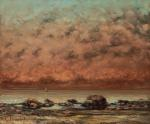
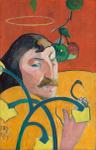
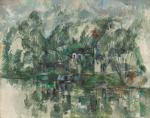
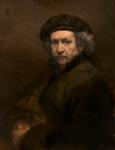
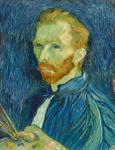
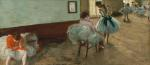
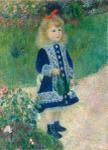
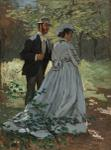
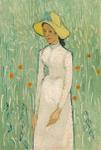
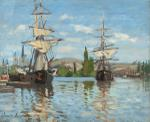

In [4]:
# Load the style and content images
styles = tc.load_images('nga/')
preview_images(styles)


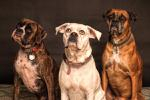

In [5]:
content = tc.load_images('content/')
preview_images(content)

In [8]:
# Create a StyleTransfer model
params = {'print_loss_breakdown': True}
model = tc.style_transfer.create(styles, content, _advanced_parameters=params)

Using 'image' in style_dataset as feature column and using 'image' in content_dataset as feature column
Setting max_iterations to be 7000
Download completed: /var/tmp/model_cache/resnet-16.params
Download completed: /var/tmp/model_cache/vgg16-conv1_1-4_3.params
Using GPU to create model (Tesla K80)
Analyzing visual features of the style images
+--------------+--------------+--------------+
| Iteration    | Loss         | Elapsed Time |
+--------------+--------------+--------------+
| 1            | 10.517       | 23.7         |
Total Loss: 10.517 | Content Loss: 28807.227 | Style Loss: 76358.531
| 10           | 9.472        | 33.9         |
Total Loss:  7.291 | Content Loss: 28051.318 | Style Loss: 44861.133
| 19           | 11.021       | 44.1         |
Total Loss:  6.932 | Content Loss: 27766.125 | Style Loss: 41551.473
| 28           | 9.640        | 54.3         |
Total Loss:  6.533 | Content Loss: 27316.988 | Style Loss: 38009.105
| 37           | 7.954        | 64.5         |
To

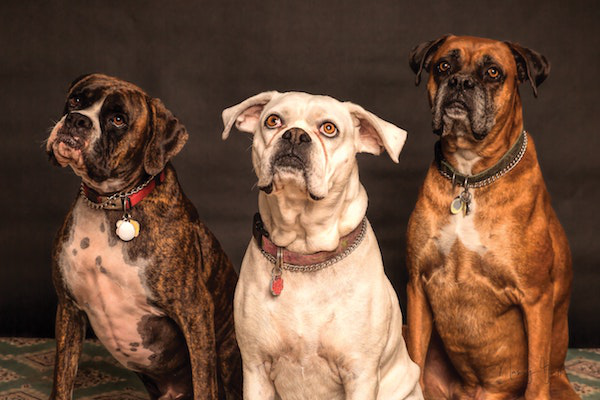

In [39]:
tcshow(content["image"][0])

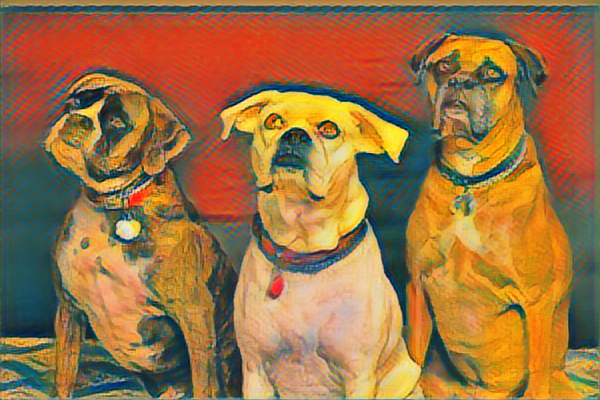

row_id,style,stylized_image
0,1,Height: 400 Width: 600


In [40]:
stylized_image = model.stylize(content, style=1)
tcshow(stylized_image["stylized_image"][0])
stylized_image


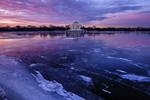
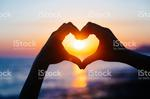
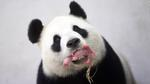
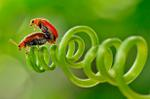
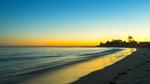
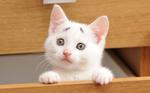
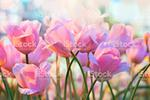
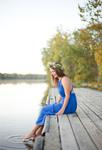
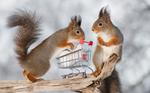
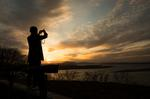
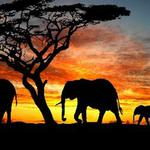
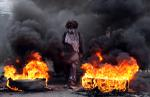
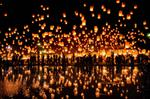
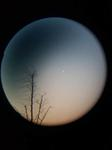
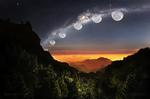
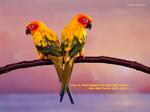
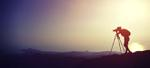
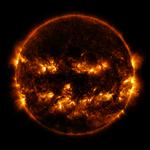
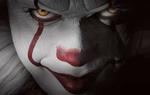
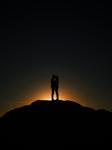
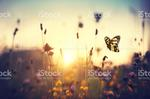
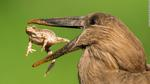
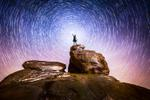
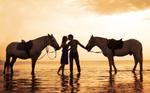
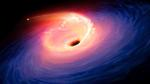
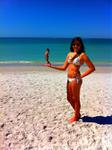
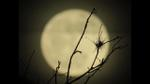
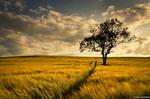
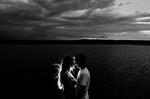
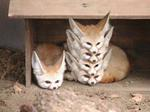

In [50]:
# Load some test images
test_images = tc.load_images('drive/My Drive/Colab Notebooks/data/test/')
preview_images(test_images)

In [0]:
# Stylize the test images
stylized_images = model.stylize(test_images)
stylized_images

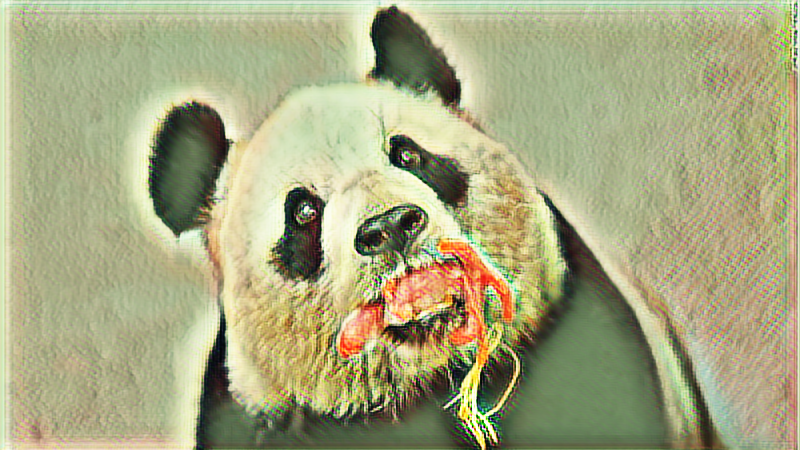

In [47]:
tcshow(stylized_images["stylized_image"][28])

By default stylize will apply all the styles of the model to each of the input images. You can also stylize using selected styles by setting the style parameter.

In [0]:
# Only the first style
stylized_image = model.stylize(test_images, style=0)
tcshow(stylized_image)

# A subset of styles
stylized_images = model.stylize(test_images, style=[1, 2])
preview_images(stylized_images)

The styles are stored inside the model as an SFrame. You can retrieve it using:

In [14]:
my_styles = model.styles
my_styles

image,style
Height: 992 Width: 1200,0
Height: 1200 Width: 771,1
Height: 944 Width: 1200,2
Height: 1200 Width: 927,3
Height: 1200 Width: 921,4
Height: 520 Width: 1200,5
Height: 1200 Width: 866,6
Height: 1200 Width: 893,7
Height: 1200 Width: 814,8
Height: 977 Width: 1200,9


## Save and Export Model

In [0]:
# Save the model for later use in Turi Create
model.save('StyleTransfer.model')

# Export for use in Core ML
model.export_coreml('StyleTransfer.mlmodel')

In [11]:
# Load model
model = tc.load_model("/content/drive/My Drive/Colab Notebooks/data/models/StyleTransfer.model")
model.summary()

Class                                    : StyleTransfer

Schema
------
Model                                    : resnet-16
Number of unique styles                  : 10
Input image shape                        : (256, 256)

Training summary
----------------
Training time                            : 2h 14m 59s
Training epochs                          : 42000
Training iterations                      : 7000
Number of style images                   : 10
Number of content images                 : 1
Final loss                               : 1.4973



In [0]:
# download mlmodel locally
from google.colab import files
files.download("StyleTransfer.mlmodel")

In [0]:
# copy model to Google Drive
from shutil import copy
copy("/content/StyleTransfer.mlmodel", "/content/drive/My Drive/Colab Notebooks/data/models/StyleTransfer.mlmodel")

In [0]:
from shutil import copytree
copytree("/content/StyleTransfer.model", "/content/drive/My Drive/Colab Notebooks/data/models/StyleTransfer.model")

## Blog articles

*   https://www.appcoda.com/coreml-turi-create/
*   https://medium.com/datadriveninvestor/turicreate-style-transfer-that-works-13b9774c70b1